# Compute Confidence Intervals
Using Bayesian parameter estimation to get confidence intervals for a reaction parameter

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from frhodo.api.optimize import BayesianObjectiveFunction
from frhodo.api.interface import compute_kinetic_coefficients, set_coefficients
from frhodo.api.driver import FrhodoDriver
from scipy import stats as ss
from pathlib import Path
from tqdm import tqdm
import numpy as np
import kombine

Configuration

In [2]:
data_path = Path('sdl-examples/diacetyl/')
key_coefficients = [
    (30, 0, 'temperature_exponent')
]
pool_size = 12

## Create the Driver
Access to the underlying system so we can get parameter values and such

In [3]:
driver = FrhodoDriver.create_driver()  # Makes it with no display
driver.load_files(
    data_path / 'experiment' / '2%-C4H6O2-in-98%-Kr-Oct-2016',
    data_path / 'mechanism', 
    data_path / 'simulation',
    aliases={
        'C4H6O2': 'CH3COCOCH3',
        'Krypton': 'Kr',
        '2,3-butanedione': 'CH3COCOCH3'
    }
)

This plugin does not support propagateSizeHints()
This plugin does not support propagateSizeHints()


Print out the starting values for our initial coefficients

In [4]:
initial_values = driver.get_coefficients(key_coefficients)
initial_values

[4.0]

## Define the objective function
We identified a key set of parameters to alter [in a previous notebook](./assess-sensitivities.ipynb).
Let's try to optimize a few of them

Our first step is to define the optimization function and we'll use a function that computes the posterior log-probability of a observing data

A first component of such a function is the probability distribution you would expect for the coefficients (which include also a data uncertainty).

**TODO**: Target the A factor for rxn #1

In [5]:
priors = [
    ss.uniform(loc=1e-6, scale=1e-4 - 1e-6),  # Data uncertainty: We expect anywhere between 1e-6 and 1e-4 with equal likelihood
    ss.uniform(loc=3.0, scale=2.0)  # Let's say the T exponent could be anywhere between 3 and 5 <--- This is where quantum chem could fit in
]
assert len(priors) == len(key_coefficients) + 1

We then combine that to make a function

In [6]:
opt = BayesianObjectiveFunction(
    data_path / 'experiment' / '2%-C4H6O2-in-98%-Kr-Oct-2016',
    data_path / 'mechanism', 
    parameters=key_coefficients,
    priors=priors,
    aliases={
        'C4H6O2': 'CH3COCOCH3',
        'Krypton': 'Kr',
        '2,3-butanedione': 'CH3COCOCH3'
    },
    num_workers=pool_size,
)
opt.load_experiments(driver)

Run an example guess using a data uncertainty of `1e-5`

In [7]:
x0 = [1e-5] + initial_values  # Input to function is the uncertainty + any new coefficients
x0

[1e-05, 4.0]

In [8]:
%%time
opt(x0)

CPU times: user 12.9 ms, sys: 33.2 ms, total: 46 ms
Wall time: 323 ms


36170.435664207005

/home/lward/miniconda3/envs/autofrhodo/lib/python3.9/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
/home/lward/miniconda3/envs/autofrhodo/lib/python3.9/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
/home/lward/miniconda3/envs/autofrhodo/lib/python3.9/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
/home/lward/miniconda3/envs/autofrhodo/lib/python3.9/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
/home/lward/miniconda3/envs/autofrhodo/lib/python3.9/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]
/home/lward/miniconda3/envs/autofrhodo/lib/python3.9/site-pa

## Running Monte Carlo Sampling
Short version: We're going to create a tool that generates a reasonable distribution of parameters given those expected values and the experimental data we've collected so far. I'll defer you to [my class materials](https://github.com/WardLT/applied-ai-for-materials/tree/main/bayesian-statistics) to get the full mathematical details

In [9]:
n_walkers = 128  # Number of samples to start with
p0 = np.vstack([  # Combines samples from each prior to form one array
    p.rvs(size=(n_walkers,)) for p in priors  # Generate random samples from each prior
]).T

`p0` contains a distribution of parameters based on our initial understanding

Our next step is to train that generator

In [10]:
%%time
# ThreadPool is OK as the largest amount of work, running simulators, is done in subprocesses
sampler = kombine.Sampler(n_walkers, p0.shape[1], opt, pool=ThreadPoolExecutor(pool_size))
burnin_data = sampler.burnin(p0)

CPU times: user 3min 32s, sys: 7.97 s, total: 3min 40s
Wall time: 11min 47s


It completes when the acceptance probability fo the sampler remains constant

Text(0, 0.5, 'P(Accept)')

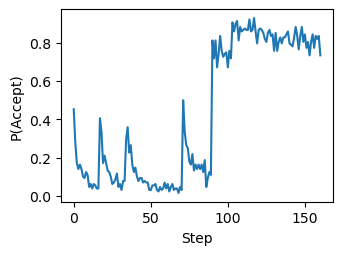

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(sampler.acceptance_fraction)

ax.set_xlabel('Step')
ax.set_ylabel('P(Accept)')

Sample the posterior

In [12]:
outputs = sampler.run_mcmc(2)

In [13]:
samples = sampler.get_samples()  # Gets only the samples after burn-in
print(f'Retrieved {len(samples)} samples from the posterior')

Retrieved 2553 samples from the posterior


Plot the posterior distribution for the parameters

Text(0.5, 0, 'Temperature parameter')

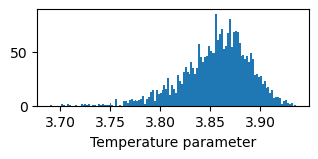

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 1.25))

ax.hist(samples[:, 1], bins=128)

ax.set_xlabel('Temperature parameter')

We can see that the temperature parameter's ideal value is somewhere between 3.8-3.9.

Next up: Run the simulations with the sampled posterior

In [15]:
sampled_sims = [opt.run_simulations(x[1:]) for x in tqdm(samples[:128])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:35<00:00,  3.59it/s]


Plot the confidence intervals for a single run

In [16]:
single_sim = np.vstack([s[5] for s in sampled_sims])

In [17]:
experiment = opt.observations[5]

Text(0, 0.5, 'Observable')

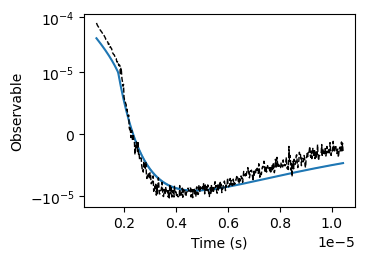

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot between the 2.5th and 97.5th percentiles
ax.fill_between(
    experiment[:, 0], np.percentile(single_sim, 2.5, axis=0), np.percentile(single_sim, 97.5, axis=0),
    alpha=0.5
)

# Plot the mean
ax.plot(experiment[:, 0], np.mean(single_sim, axis=0))
ax.plot(experiment[:, 0], experiment[:, 1], 'k--', lw=1)

ax.set_yscale('symlog', linthresh=1e-5)  # TODO (wardlt): Fix this

ax.set_xlabel('Time (s)')
ax.set_ylabel('Observable')

## Find the reaction conditions where the uncertainty is the highest
Let's look at reaction #30 and see how closely we know it for different reaction conditions

In [19]:
tpx = opt.rxn_conditions[5]
print(f'Starting conditions: T - {tpx[0]:.2f} K, P - {tpx[1]:.1e} torr, X - {tpx[2]}')

Starting conditions: T - 1513.67 K, P - 1.6e+04 torr, X - {'Kr': 0.98, 'CH3COCOCH3': 0.02}


See what our uncertainty in $k$ is for this condition

In [20]:
k_samples = []
for params in tqdm(samples):
    set_coefficients(opt.mech, dict(zip(key_coefficients, params[1:])))
    k_samples.append(compute_kinetic_coefficients(opt.mech, tpx)[30])    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2553/2553 [00:01<00:00, 2410.19it/s]


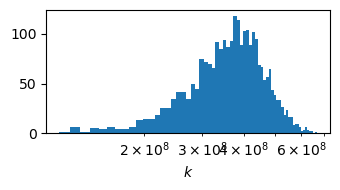

In [21]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

#bins = np.logspace(8, 9, 32)
ax.hist(k_samples, bins=64)

ax.set_xscale('log')
ax.set_xlabel('$k$')

fig.tight_layout()

In [22]:
print(f'The kinetic coefficient is {np.mean(k_samples):.2e} +/ {np.std(k_samples):.1e}')

The kinetic coefficient is 3.82e+08 +/ 8.9e+07


It is pretty well-defined under thes attention

Let's see how well it does at other temperatures and pressures

In [23]:
tt, pp = np.meshgrid(
    np.linspace(1200, 1800, 16),
    np.linspace(10000, 20000, 16)
)

In [24]:
kk_std = []
for t, p in tqdm(zip(tt.flatten(), pp.flatten()), total=np.size(tt)):
    tpx = (t, p, tpx[2])
    k_samples = []
    for params in samples:
        set_coefficients(opt.mech, dict(zip(key_coefficients, params[1:])))
        k_samples.append(compute_kinetic_coefficients(opt.mech, tpx)[30])
    kk_std.append(np.std(k_samples))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [04:35<00:00,  1.08s/it]


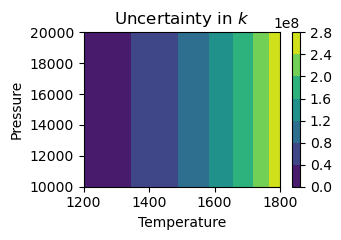

In [25]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

kk_std = np.reshape(kk_std, tt.shape)

cb_info = ax.contourf(tt, pp, kk_std)

fig.colorbar(cb_info)

ax.set_title('Uncertainty in $k$')
ax.set_xlabel('Temperature')
ax.set_ylabel('Pressure')

fig.tight_layout()

We can see that experiments at larger temperatures could help reduce uncertainty the most